# 2025期末考核——光伏阵列分割
## 案例背景知识

光伏阵列分割：输入一张包含光伏阵列图片，识别出其中属于光伏阵列像素。需要利用给定的数据集，用算法实现。

本次给定训练数据集一共包含了2693张图像，测试集A包含336张图像，测试集B包含338张图像，测试集B将在最后一天公布，最终分数以测试集B为准。

## 案例思路
>
+ 导入相关库
+ 加载图像数据
+ 定义网络结构
+ 定义训练模型函数
+ 训练模型
+ 提交结果文件

## 数据描述
原始训练集train文件夹中共有两种JPG图像文件，以**image数字**命名的为原始红外图像，**mask数字**命名为对应的分割标签，其中白色像素点标记光伏阵列，黑色像素点为背景。

## 测评指标
使用交并比Interaction of Union (IoU)作为测评指标：(https://www.cnblogs.com/Fish0403/p/17117778.html)，定义如下。
$$\text{ IoU } = \frac{ \text { TP } } { \text { TP }+\text { FP }+\text { FN } } $$

保存的测试文件为**predict+数字**的JPG文件，输出文件与原图像尺寸保持一致，均为160*128。

例如 image0.JPG 的图像输出为 predict0.JPG

## 输入学号信息

In [5]:
student_id = ''
#输入学号，不输入或者输错则没有成绩

## 导入相关库

In [ ]:
import os
import sys
import torch
import torch.nn as nn
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from typing import Optional
from tqdm import tqdm
from tabulate import tabulate
from PIL import Image
from codecarbon import EmissionsTracker
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader

## 加载图像数据
1. 数据加载类封装

In [ ]:
ROOT_DIR = "D:/data/DL_course2025"
images_dir = os.path.join(ROOT_DIR, "train/")
batch_size = 2
num_workers = 0
image_names = [file for file in os.listdir(images_dir) if file.endswith('.JPG') and file.startswith('image')]
mask_names = [file for file in os.listdir(images_dir) if file.endswith('.JPG') and file.startswith('mask')]

In [ ]:
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, image_names, mask_names, transform: Optional[A.Compose] = None):
        self.image_dir = image_dir
        self.image_names = image_names
        self.mask_names = mask_names
        self.transform = transform

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        mask_name = self.mask_names[idx]
        image_path = os.path.join(self.image_dir, image_name)
        label_path = os.path.join(self.image_dir, mask_name)

        image = np.array(Image.open(image_path).convert("RGB")).astype(np.float32) / 255.0
        label = np.array(Image.open(label_path)).astype(np.float32) / 255.0
        
        if self.transform:
            augmented = self.transform(image=image, mask=label)
            image = augmented["image"]
            label = augmented["mask"].unsqueeze(0)

        return image, label, image_name, mask_name
    
    
def get_loaders(
    image_names: list[str],
    mask_names: list[str],
    images_dir: str,
    batch_size: int = 2,
    train_transform: Optional[A.Compose] = None,
    val_test_transform: Optional[A.Compose] = None,
    seed: int = 42,
) -> DataLoader | DataLoader | DataLoader:
    """
    Create DataLoader objects for the training, validation, and test sets.

    Args:
        image_names (list): List of image names to include in the dataset.
        mask_names (list): List of mask names to include in the dataset.
        images_dir (str): Path to the directory containing the original images.
        batch_size (int): Batch size for the DataLoader objects.
        transform (Optional[A.Compose]): Transform to apply to the images and masks.
        seed (int): Seed for the random number generator.

    Returns:
        tuple: (train_loader, val_loader, test_loader)
    """
    # Split the dataset into training, validation, and test sets
    generator = torch.Generator().manual_seed(seed)
    dataset = SegmentationDataset(images_dir, image_names, mask_names)
    train_dataset, val_dataset = torch.utils.data.random_split(
        dataset, [0.8, 0.2], 
        generator=generator
    )
    
    # Apply the transforms to the datasets
    train_dataset.dataset.transform = train_transform
    val_dataset.dataset.transform = val_test_transform
    
    # Create DataLoader objects
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    return train_loader, val_loader

2. 数据增强(学生可修改)

In [ ]:
train_transform = ToTensorV2()
val_test_transform = ToTensorV2()
batch_size = 2

images_train_loader, images_val_loader = get_loaders(
    image_names=image_names,
    mask_names=mask_names,
    images_dir=images_dir, 
    batch_size=batch_size, 
    train_transform=train_transform, 
    val_test_transform=val_test_transform
)

table_data = [["Train", len(images_train_loader) * batch_size],
              ["Validation", len(images_val_loader) * batch_size]]
print(tabulate(table_data, headers=["Dataset Split", "Number of Images"], tablefmt="fancy_grid"))

╒═════════════════╤════════════════════╕
│ Dataset Split   │   Number of Images │
╞═════════════════╪════════════════════╡
│ Train           │               2156 │
├─────────────────┼────────────────────┤
│ Validation      │                538 │
╘═════════════════╧════════════════════╛


### 定义网络结构
（Model结构可修改）

In [ ]:
class UNet(nn.Module):
    def __init__(self, nb_layers: int, kernel_size: int):
        """
        Create a U-Net model with the given number of layers and kernel size.
        
        Args:
            nb_layers (int): Number of layers in the encoder, either 2 or 3.
            kernel_size (int): Kernel size of the convolutional layers.
        """
        super().__init__()
        encoder = []
        for i in range(nb_layers):
            in_channels, out_channels = 3 if i == 0 else 2 ** (5 + i), 2 ** (6 + i)
            padding = kernel_size // 2
            encoder.append(
                nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding)
            )
            encoder += [nn.ReLU(), nn.MaxPool2d(2)]
        self.encoder = nn.Sequential(*encoder)

        decoder = []
        for i in range(nb_layers - 1):
            in_channels, out_channels = 2 ** (5 + nb_layers - i), 2 ** (4 + nb_layers - i)
            decoder.append(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
            )
            decoder.append(nn.ReLU())
            
        decoder.append(nn.ConvTranspose2d(2**6, 1, kernel_size=2, stride=2))
        decoder.append(nn.Sigmoid())
        self.decoder = nn.Sequential(*decoder)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

## 定义训练模型函数

In [ ]:
def train_unet(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    criterion: nn.Module,
    lr: float,
    epochs: int,
    patience: int,
    device: torch.device = torch.device("cpu"),
) -> list[float] | list[float]:
    """
    Train U-Net with early stopping, computing training and validation losses. Also compute
    the carbon emissions during training.

    Args:
        model (torch.nn.Module): U-Net model to be trained.
        train_loader (DataLoader): DataLoader for the training set.
        val_loader (DataLoader): DataLoader for the validation set.
        criterion (torch.nn.Module): Loss function to use.
        lr (float): Learning rate for the optimizer.
        epochs (int): Maximum number of epochs to train (default: 50).
        patience (int): Number of epochs to wait for improvement before early stopping.
        device (torch.device): Device to run the training on (e.g., 'cuda', 'mps', or 'cpu').

    Returns:
        train_losses (list): List of training losses per epoch.
        val_losses (list): List of validation losses per epoch.
    """
    tracker = EmissionsTracker(log_level="critical", save_to_file=False)
    tracker.start()
    
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []
    best_val_loss = float("inf")
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for image, label, _, _ in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
            image, label = image.to(device), label.to(device)
            outputs = model(image)
            loss = criterion(outputs, label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"Epoch {epoch+1}/{epochs}, Training Loss: {avg_train_loss:.4f}")

        # Validation loop
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for image, label, _, _ in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}"):
                image, label = image.float().to(device), label.float().to(device)
                outputs = model(image)
                loss = criterion(outputs, label)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        print(f"Validation Loss: {avg_val_loss:.4f}")

        # Early stopping logic
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            print(
                f"Validation loss did not improve. Patience counter: {patience_counter}/{patience}"
            )

        if patience_counter >= patience:
            print("Early stopping triggered!")
            break

    emissions = tracker.stop()
    print(f"Training complete, emitted {emissions} kgCO2")
    return train_losses, val_losses

## 模型训练

In [ ]:
patience = 3
criterion = nn.BCELoss()
device = torch.device(
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using device: {device}")

# 超参数设置
nb_layers, kernel_size, lr, epochs = 2, 5, 3e-4, 10

Using device: cuda


In [ ]:
def plot_losses(train_losses: list[float], val_losses: list[float]):
    """
    plots the training and validation losses over epochs.

    Args:
        train_losses (list): List of training losses per epoch.
        val_losses (list): List of validation losses per epoch.
    """

    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label="Training Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Over Epochs")
    plt.legend()
    plt.grid()
    plt.show()

[codecarbon WARNING @ 18:46:10] Multiple instances of codecarbon are allowed to run at the same time.
Training Epoch 1: 100%|██████████| 1078/1078 [00:16<00:00, 64.43it/s]


Epoch 1/10, Training Loss: 0.3502


Validation Epoch 1: 100%|██████████| 269/269 [00:03<00:00, 74.42it/s]


Validation Loss: 0.3349


Training Epoch 2: 100%|██████████| 1078/1078 [00:04<00:00, 218.09it/s]


Epoch 2/10, Training Loss: 0.2854


Validation Epoch 2: 100%|██████████| 269/269 [00:00<00:00, 460.57it/s]


Validation Loss: 0.2833


Training Epoch 3: 100%|██████████| 1078/1078 [00:04<00:00, 226.09it/s]


Epoch 3/10, Training Loss: 0.2583


Validation Epoch 3: 100%|██████████| 269/269 [00:00<00:00, 460.62it/s]


Validation Loss: 0.2571


Training Epoch 4: 100%|██████████| 1078/1078 [00:04<00:00, 227.15it/s]


Epoch 4/10, Training Loss: 0.2284


Validation Epoch 4: 100%|██████████| 269/269 [00:00<00:00, 462.83it/s]


Validation Loss: 0.2276


Training Epoch 5: 100%|██████████| 1078/1078 [00:04<00:00, 225.59it/s]


Epoch 5/10, Training Loss: 0.2036


Validation Epoch 5: 100%|██████████| 269/269 [00:00<00:00, 451.30it/s]


Validation Loss: 0.1915


Training Epoch 6: 100%|██████████| 1078/1078 [00:04<00:00, 228.69it/s]


Epoch 6/10, Training Loss: 0.1834


Validation Epoch 6: 100%|██████████| 269/269 [00:00<00:00, 470.28it/s]


Validation Loss: 0.1730


Training Epoch 7: 100%|██████████| 1078/1078 [00:04<00:00, 226.26it/s]


Epoch 7/10, Training Loss: 0.1707


Validation Epoch 7: 100%|██████████| 269/269 [00:00<00:00, 470.28it/s]


Validation Loss: 0.1688


Training Epoch 8: 100%|██████████| 1078/1078 [00:04<00:00, 228.62it/s]


Epoch 8/10, Training Loss: 0.1592


Validation Epoch 8: 100%|██████████| 269/269 [00:00<00:00, 461.41it/s]


Validation Loss: 0.1628


Training Epoch 9: 100%|██████████| 1078/1078 [00:04<00:00, 228.52it/s]


Epoch 9/10, Training Loss: 0.1517


Validation Epoch 9: 100%|██████████| 269/269 [00:00<00:00, 459.80it/s]


Validation Loss: 0.1482


Training Epoch 10: 100%|██████████| 1078/1078 [00:04<00:00, 227.61it/s]


Epoch 10/10, Training Loss: 0.1456


Validation Epoch 10: 100%|██████████| 269/269 [00:00<00:00, 459.83it/s]


Validation Loss: 0.1527
Validation loss did not improve. Patience counter: 1/3
Training complete, emitted 0.002144265501550657 kgCO2


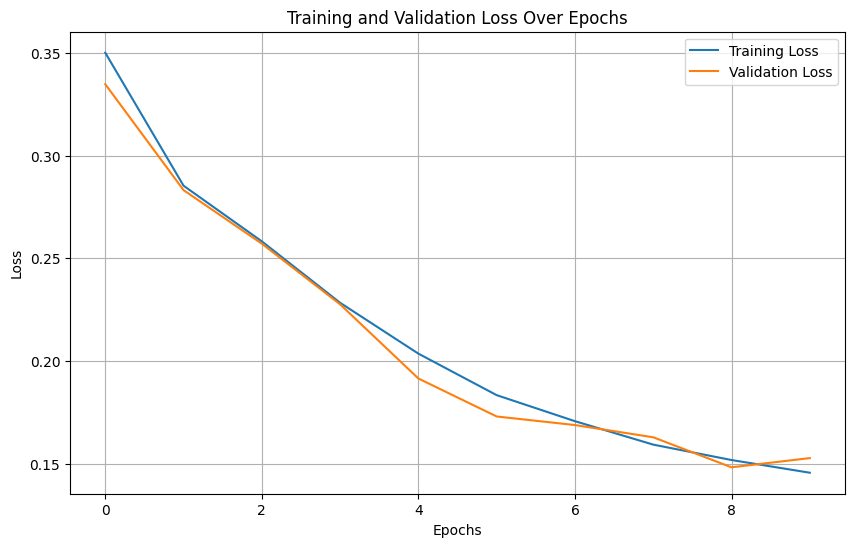

In [ ]:
model = UNet(nb_layers=nb_layers, kernel_size=kernel_size)

train_losses, val_losses = train_unet(
    model=model,
    train_loader=images_train_loader,
    val_loader=images_val_loader,
    device=device,
    criterion=criterion,
    lr=lr,
    epochs=epochs,
    patience=patience
)
plot_losses(train_losses, val_losses)

> 现在我们的模型已经训练好了，我们还有另一个重要的值需要计算。事实上，我们的模型输出了输入图像中每个像素是太阳能电池板一部分的概率。我们需要确定最优概率 **阈值**，超过该阈值后，我们是否将像素归类为 “太阳能电池板”。


In [ ]:
threshold = 0.271

> 预测结果可视化

In [ ]:
def predict(
    model: nn.Module,
    test_loader: DataLoader,
    idx: int,
    threshold: float = 0.2,
    device: torch.device = torch.device("cpu")
) -> Image.Image | np.ndarray | np.ndarray:
    """
    Evaluate a segmentation model on a single image and return the predicted mask.
    
    Args:
        model (torch.nn.Module): Trained model for segmentation.
        test_loader (torch.utils.data.DataLoader): Data loader for the test dataset.
        idx (int): Index of the image to evaluate.
        roof_masks_dir (str): Path of directory containing masks of roof areas (only used if post_process is True).
        device (torch.device): Device to perform computations on (e.g., "cuda" or "cpu")
        
    Returns:
        PIL.Image.Image: Real image.
        np.ndarray: Ground truth mask for the image.
        np.ndarray: Predicted mask for the image.
    """
    model.eval()
    with torch.no_grad():
        image, label, image_name, mask_name = test_loader.dataset[idx]
        
        # Run predictions
        input_image, label_image = image.to(device), label.to(device)
        predicted_output = (
            model(input_image).cpu().squeeze() > threshold
        ).numpy().astype(np.uint8) * 255
        
        # Retrieve real image and ground truth mask
        real_image = Image.fromarray((image.permute(1, 2, 0).numpy() * 255).astype(np.uint8))
        ground_truth_mask = (label_image.cpu().squeeze().numpy() * 255).astype(np.uint8)

    return real_image, ground_truth_mask, predicted_output

In [ ]:
def plot_prediction(
    real_image: Image,
    ground_truth: np.ndarray,
    predicted_mask: np.ndarray,
):
    """
    Visualize the output of a segmentation model.

    Args:
        model (nn.Module): trained model
        test_loader (DataLoader): test data loader
        idx (int): index of the image to visualize
        threshold (float): threshold for binary predictions
        post_process (bool): whether to apply post-processing to the predicted mask
        roof_masks_dir (str): directory containing roof masks
        device (torch.device): device to perform computations on
    """
    _, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(real_image)
    axes[0].set_title("Input Image")
    axes[0].axis("off")

    axes[1].imshow(ground_truth, cmap="gray")
    axes[1].set_title("Ground Truth Mask")
    axes[1].axis("off")

    axes[2].imshow(predicted_mask, cmap="gray")
    axes[2].set_title("Predicted Segmentation")
    axes[2].axis("off")

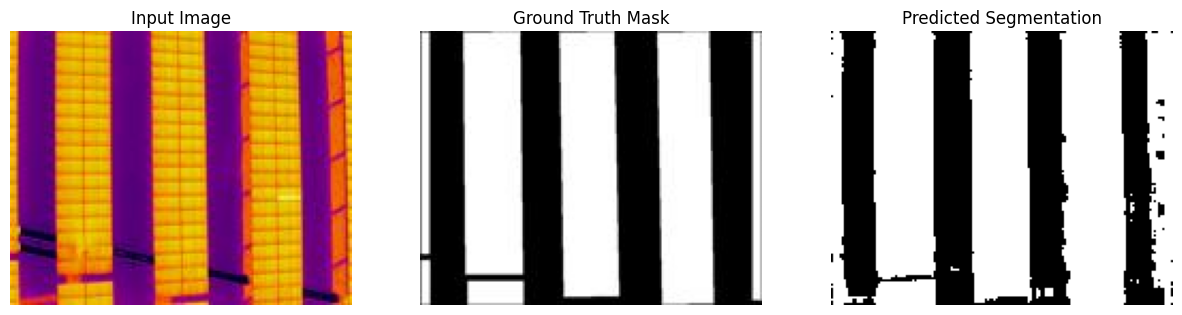

In [ ]:
test_idx = 35
real_image, ground_truth, prediction = predict(
    model=model, 
    test_loader=images_val_loader,
    idx=test_idx, 
    threshold=threshold,
    device=device
)
plot_prediction(real_image, ground_truth, prediction)

## 提交结果

### 预测结果并保存为.JPG文件

保存的预测文件为**predict+数字**的JPG文件，输出文件与原图像尺寸保持一致，均为160*128。

例如 image0.JPG 的图像输出为 predict0.JPG

### 所有预测结果存储在个人学号目录，并上传至ftp

In [ ]:
def inference(model, image_path, transform=None, device='cpu'):
    image = np.array(Image.open(image_path).convert("RGB")).astype(np.float32) / 255.0
    if transform:
        augmented = transform(image=image)
        image = augmented["image"]
    image = image.to(device)
    # 进行前向推断
    predicted_output = (
            model(image).cpu().squeeze() > threshold
        ).numpy().astype(np.uint8) * 255
        
    return predicted_output

In [ ]:
# 禁止删改该代码！
student_id_dir = student_id

In [ ]:
test_dir = 'data/testA' #测试数据A榜在testA文件夹，测试数据B榜在testB文件夹

if not os.path.exists(student_id_dir):
    os.makedirs(student_id_dir, exist_ok=True)

test_images = [file for file in os.listdir(test_dir) if file.endswith('.JPG') and file.startswith('image')]
# 设定为评估模式，禁用了所有 dropout 和 batch normalization 层的影响
model.eval()
res = []
val_test_transform = ToTensorV2()
# 使用 with torch.no_grad(): 包含调用，可以减少内存开销和加速
with torch.no_grad():
    # 使用test_loader遍历测试集的数据和文件ID
    for idx, image_name in enumerate(test_images):
        # 将数据移动到设备上
        image_path = os.path.join(test_dir, image_name)
        output = inference(model, image_path, val_test_transform, device)
        saved_predict = Image.fromarray(output)
        saved_predict.save(os.path.join(student_id_dir, "predict" + str(idx) + ".JPG"), format="JPEG")
